In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

import warnings 
# Filter Warnings 
warnings.filterwarnings('ignore')

from PIL import Image
import os
from sklearn.metrics import accuracy_score

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

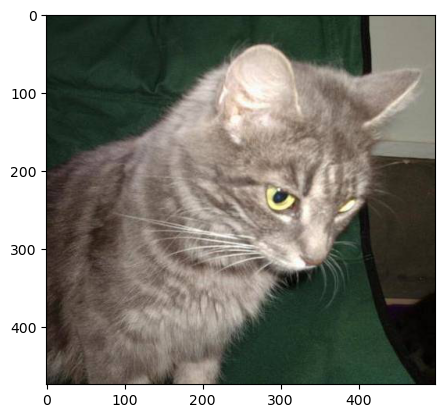

In [3]:
#base_dir = '/kaggle/input/dogs-cats-images/dataset'
#base_dir = '/Users/leonjye/Downloads/CatAndDog'
base_dir = r'C:\Users\leonjye\Documents\DeepLearning\DogAndCat\dataset'
PATH_TRAIN_CAT = base_dir + '/training_set/cats' 
PATH_TRAIN_DOG = base_dir + '/training_set/dogs' 
PATH_TEST_CAT = base_dir + '/test_set/cats' 
PATH_TEST_DOG = base_dir + '/test_set/dogs' 
 
DOG = 0
CAT = 1

IMG_WIDTH = 200 
IMG_HEIGHT = 200 
NR_PIX = IMG_HEIGHT * IMG_WIDTH
NR_CHANELS = 3 # 全彩RGB
NR_FEATURES = NR_PIX * NR_CHANELS # 輸入的特徵值就是所有pixel乘上RGB


import random
image = Image.open(f'{PATH_TRAIN_CAT}/cat.{random.randint(1,4000)}.jpg')
plt.imshow(np.asarray(image))

In [4]:
def load_data_asanarray(path):
    data = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            specific_path = os.path.join(dirname, filename)
            if not specific_path.endswith('.jpg'):
                continue
            image = Image.open(specific_path).resize((IMG_WIDTH,IMG_HEIGHT))
            img_array = np.asarray(image, dtype=np.float32)
            data.append(img_array)
    return np.asarray(data)

In [5]:
%%time
data_train_cat = load_data_asanarray(PATH_TRAIN_CAT)
data_train_dog = load_data_asanarray(PATH_TRAIN_DOG)
print('data_train_cat:', data_train_cat.shape)
print('data_train_dog:', data_train_dog.shape)
y_label_cat = np.ones(len(data_train_cat))
y_label_dog = np.zeros(len(data_train_dog))

x_train = np.concatenate((data_train_cat, data_train_dog))
y_train = np.concatenate((y_label_cat, y_label_dog))

data_train_cat: (4000, 200, 200, 3)
data_train_dog: (4000, 200, 200, 3)
CPU times: total: 6.12 s
Wall time: 49.1 s


In [6]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42, stratify=y_train)

In [7]:
class CatDog_dataset:
    def __init__(self, X, y):
        X /= 255.0
        self.X = torch.from_numpy(X).to(device)
        self.y = torch.from_numpy(y).view(-1, 1).to(device)
        #因為最後計算的形狀會是[[1],[0],...[0]]二維，所以把原本的一維的y變成2維資料
        #比方說原本y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## torch.tensor.view(-1,1)說明
    因為最後計算的形狀會是[[1],[0],...[0]]二維，所以把原本的一維的y變成2維資料
    比方說原本y是(1000,)，變成(1000,1)

In [8]:
train_dataset = CatDog_dataset(x_train, y_train)
val_dataset = CatDog_dataset(x_val, y_val)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [9]:
from torch import nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NR_FEATURES, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
mlp = MLP()
mlp.to(device)
print(mlp)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=0.01)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=120000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [22]:
from torchinfo import summary

summary(mlp, input_size=(1, 120000))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 64]                   7,680,064
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 32]                   2,080
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 1]                    33
Total params: 7,682,177
Trainable params: 7,682,177
Non-trainable params: 0
Total mult-adds (M): 7.68
Input size (MB): 0.48
Forward/backward pass size (MB): 0.00
Params size (MB): 30.73
Estimated Total Size (MB): 31.21

In [11]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [12]:
for epoch in range(50):
    running_loss = 0.0
    corrects = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        # 1.Define variables
        images = images.view(-1, NR_FEATURES)
        labels = labels
        # 2.Forward pass
        outputs = mlp(images)
        # 3.Calculate loss
        loss = loss_function(outputs, labels.float())
        # 4.Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total += len(labels)
        predicted = torch.sigmoid(outputs).round().cpu().detach().numpy()
        corrects += (predicted == labels.cpu().detach().numpy()).sum()
        #if i % 10 == 0:
            #print('Epoch: %d, Iteration: %d, Loss: %.4f' % (epoch, i, loss.item()))
    train_losses.append(running_loss/total)
    train_accuracies.append(corrects*100/total)

    ## valdate
    with torch.no_grad():
        val_result = mlp(val_dataset.X.view(-1, NR_FEATURES))
        val_loss = loss_function(val_result, val_dataset.y.float()).item()
        val_losses.append(val_loss)
        y_pred = torch.sigmoid(val_result).round().cpu().detach().numpy()
        val_acc = accuracy_score(val_dataset.y.cpu().detach().numpy(), y_pred)*100
        val_accuracies.append(val_acc)
    print(f'epoch:{epoch}, train_loss: {running_loss/total:.2f}, train_accuracy: {corrects*100/total:.2f}, val_loss: {val_loss:.2f}, val_accuracy: {val_acc:.2f}')


epoch:0, train_loss: 0.70, train_accuracy: 53.88, val_loss: 0.69, val_accuracy: 56.56
epoch:1, train_loss: 0.69, train_accuracy: 54.14, val_loss: 0.68, val_accuracy: 56.69
epoch:2, train_loss: 0.69, train_accuracy: 53.95, val_loss: 0.68, val_accuracy: 53.56
epoch:3, train_loss: 0.68, train_accuracy: 55.27, val_loss: 0.69, val_accuracy: 52.44
epoch:4, train_loss: 0.68, train_accuracy: 56.31, val_loss: 0.69, val_accuracy: 55.00
epoch:5, train_loss: 0.69, train_accuracy: 54.34, val_loss: 0.68, val_accuracy: 56.75
epoch:6, train_loss: 0.68, train_accuracy: 56.81, val_loss: 0.68, val_accuracy: 57.69
epoch:7, train_loss: 0.69, train_accuracy: 54.20, val_loss: 0.68, val_accuracy: 54.00
epoch:8, train_loss: 0.69, train_accuracy: 54.23, val_loss: 0.68, val_accuracy: 57.19
epoch:9, train_loss: 0.68, train_accuracy: 56.17, val_loss: 0.68, val_accuracy: 56.69
epoch:10, train_loss: 0.68, train_accuracy: 57.77, val_loss: 0.68, val_accuracy: 55.88
epoch:11, train_loss: 0.68, train_accuracy: 57.17, va

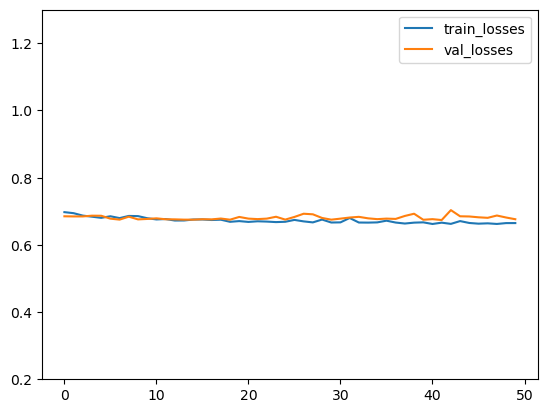

In [13]:
plt.plot(train_losses, label='train_losses')
plt.plot(val_losses, label='val_losses')
plt.legend()
plt.ylim(0.2, 1.3)
plt.show()

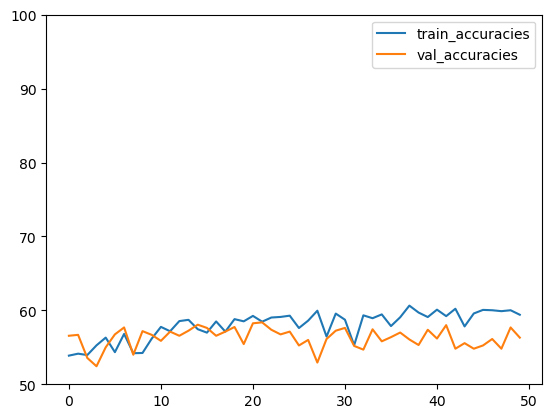

In [14]:
plt.plot(train_accuracies, label='train_accuracies')
plt.plot(val_accuracies, label='val_accuracies')
plt.legend()
plt.ylim(50, 100)
plt.show()

In [15]:
#### test ####
print('跑看看準確率')
test_result = mlp(train_dataset.X.view(-1, NR_FEATURES))
y_pred = torch.sigmoid(test_result).round().to('cpu').detach().numpy()

跑看看準確率


In [16]:
accuracy_score(y_train, y_pred)

0.6296875

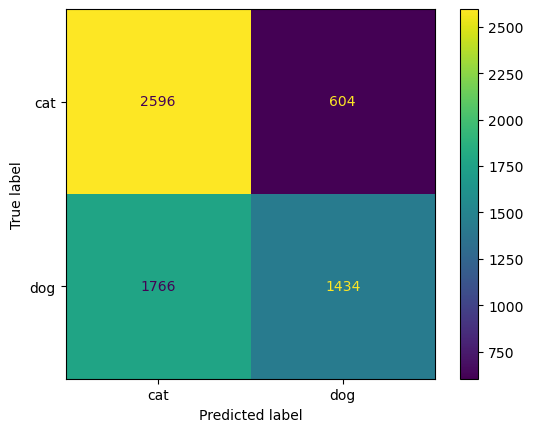

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
disp.plot()

In [18]:
#### test ####
print('testing..')
data_test_cat = load_data_asanarray(PATH_TEST_CAT)
data_test_dog = load_data_asanarray(PATH_TEST_DOG)
print('data_test_cat:', data_test_cat.shape)
print('data_test_dog:', data_test_dog.shape)
y_test_cat = np.ones(len(data_test_cat))
y_test_dog = np.zeros(len(data_test_dog))
x_test = np.concatenate((data_test_cat, data_test_dog))
y_test = np.concatenate((y_test_cat, y_test_dog))
test_dataset = CatDog_dataset(x_test, y_test)
test_result = mlp(test_dataset.X.view(-1, NR_FEATURES))
y_pred = torch.sigmoid(test_result).cpu().round().detach().numpy()

testing..
data_test_cat: (1000, 200, 200, 3)
data_test_dog: (1000, 200, 200, 3)


In [19]:
accuracy_score(y_test, y_pred)

0.591

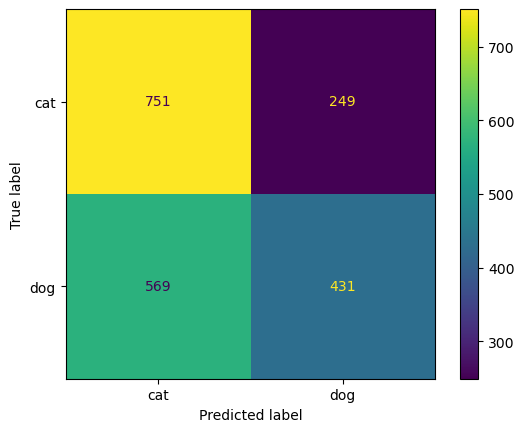

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
disp.plot()

In [31]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,200,200)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) #output_shape=(16,28,28)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,14,14)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) #output_shape=(32,14,14)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(3*3*32, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [32]:
model = CNN_Model()
model

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=10, bias=True)
)

In [40]:
#https://www.kaggle.com/code/minhhngchong/cat-and-dog
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in trainloader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = loss_function(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(trainloader)
        epoch_loss += loss/len(trainloader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[10, 200, 200, 3] to have 3 channels, but got 200 channels instead